In [53]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [54]:
basedir = 'D:/lalamove/lalamove/data/Clean_1s_all_240103/train'
labels = [5, 6, 7]
with open(basedir + '/../data_split_params.json', 'r') as file:
    features = json.load(file)['FEATURES']
print(features)

{'5': ['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh'], '6': ['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh'], '7': ['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh']}


In [68]:
label = 7
synthetic_percent = 0.1

In [69]:
y = pd.read_csv(basedir + f'/{label}/train_label_{label}.csv')
X = []
step = 30_000
for i in range(np.ceil(len(y)/30_000).astype(int)):
    temp = pd.read_csv(basedir + f'/{label}/extract_features_{label}_{i}.csv', index_col=0)
    X.append(temp)
X = pd.concat(X)
assert len(X) == len(y), f"Length mismatch {len(X)}, {len(y)}"

In [70]:
X.shape, y.shape

((381067, 500), (381067, 6))

In [78]:
dates = y.date.unique()
chosen = dates[-3]
test_idx = y[(y.date == chosen) & (y.type == 0)].index
train_idx = y[(y.date != chosen) & (y.type == 0)]
train_idx_add = y[(y.date != chosen) & (y.type == 1)].sample(frac=synthetic_percent)
train_idx = pd.concat([train_idx, train_idx_add]).index
# train_idx = y[(y.date != chosen)].index

X_train_, X_test_ = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx].label, y.iloc[test_idx].label

In [79]:
print(chosen)

20231228


In [80]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)

# X_train = X_train.reshape(-1, 20, 25)
# X_test = X_test.reshape(-1, 20, 25)

In [81]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [82]:
model_file = r"D:\lalamove\lalamove\data\Clean_1s_all_240103\model_ann\7\model_7_test_date_20231201_spercent_0.1.hdf5"
model = tf.keras.models.load_model(model_file)

predictions = model.predict(X_test) >= 0.5
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
print('accuracy: {0:.4f}, recall: {1:.4f}, precision: {2:.4f}'.format(accuracy, recall, precision))
print(y_test.shape, predictions.shape)
min_len = min(len(y_test), len(predictions))
cm = confusion_matrix(y_test[:min_len], predictions[:min_len] > 0.5)
print(cm)

427/427 [==============================] - 2s 3ms/step
accuracy: 0.9862, recall: 0.7786, precision: 0.7749
(13649,) (13649, 1)
[[13134    95]
 [   93   327]]


427/427 [==============================] - 1s 1ms/step
(13649,) (13649,)
(13649,) (13649,)
type
True Positive       334
True Negative     13199
False Positive       30
False Negative       86
Name: count, dtype: int64


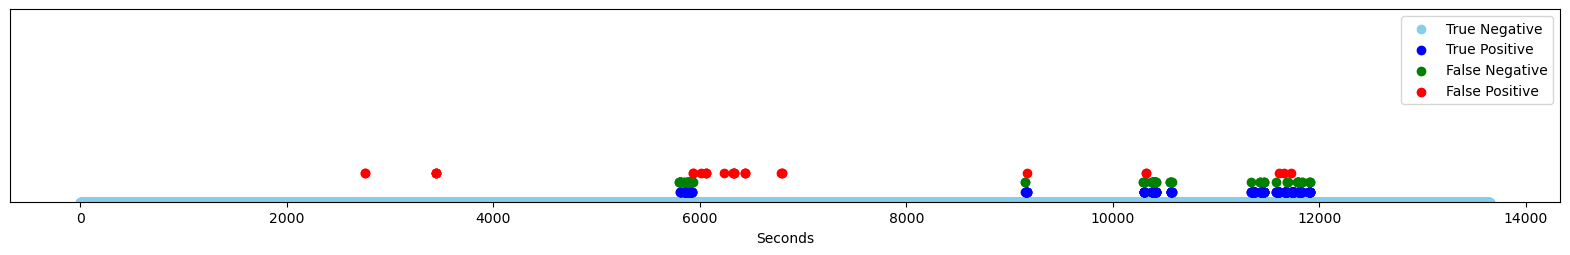

In [83]:
pred = model.predict(X_test).flatten() 
print(pred.shape, y_test.shape)
w = 5 # window in seconds
pred = np.convolve(pred, np.ones(w), mode='same') / w >= 0.5

print(pred.shape, y_test.shape)
df = pd.DataFrame(np.stack((y_test, pred)).T, columns=['true', 'pred'])
df.pred = df.pred.astype(int)

def classify(row):
    true, pred = row.true, row.pred
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'
    
df['type'] = df.apply(lambda x: classify(x), axis=1)
types = df.type.value_counts().sort_index()[::-1]
print(types)

fig, ax = plt.subplots(figsize=(20, 2.5))
i = 0
colors = ['skyblue', 'blue', 'green', 'red']
types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for j, t in enumerate(types_):
    try:
        ax.scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
    except KeyError:
        print(f'There is no {t}')
    i += 0.1

ax.legend()
ax.set_ylim(0, 2)
ax.set_xlabel('Seconds')
ax.get_yaxis().set_visible(False)
# ax.set_title(f'{features[str(label)]}')